# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1. Business understanding

The Starbucks rewards app allows users to earn rewards when they pay through that app. The process of earning rewards consists of receiving, displaying and completing offers. One important issue concerns the responsiveness of app users who receive offers:

- Could the response of a given user to a given offer be precited ? Will a given user respond to a given offer ?
- What are the most importants factors when it is about to predict the responsiveness of a user to an offer ?

- Which are the most accepted offers ?
- Which are the most beneficial offers from the perspective of revenues ?
- What is the profile of the typical/ideal target user (age, income, gender) ?

The answers to these questions could help the company in various ways. By avoiding sending offers to users who are less likely to respond, the company could save advertising costs. This would also allow the company to work more efficiently by targeting those people who are more likely to respond to certain offers. The section "Exploratory Data Analysis" below gives deep insights into the data. The conclusion at the end of this Jupyter notebook provides a summary of the answers to all questions asked here.

# 2. Data understanding

The data set consists of 3 categories of data:
- Portfolio data
- Profile data 
- Transcript data

Portfolio data contain offer details: communication channels, offer type, difficulty, duration, reward.
These details could impact the decision of the user to repond to the offer or not.

Profile data contain demographics of the user: age, income, gender, date where the user became member.
These details could explain the decision or a user to complete an offer or not. 

Transcript data contain details about the interactions between user and offer: receiving time, review time, completion time, amount of money paid.

### Response information

On the first view, it is not clear whether a user has responded to an offer or not. That's why it is necessary to define the criteria of a successful response. An offer is considered as successfuly responded by a user if and only if:

- Transcript records of the offer are marked as received, viewed and completed by the user.
- Offer is received, viewed and completed within the valid duration (validity)
- Offer is viewed before completion (consistency)

The response information could be extracted from transcript and portfolio data described above.

Finally, portfolio, profile and transcript data will be used to build a machine learning model to predict the response of a user to an offer.

In [1]:
# Module imports

import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

import seaborn as sb

from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectFromModel

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, datasets


from IPython.display import clear_output, display
import time


# 3. Data Preparation

## 3.1 Data Access

In [2]:
# read in data from json files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head(3) # displaying raw portfolio data

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0


In [4]:
profile.head(3) # displaying raw profile data

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN


In [5]:
transcript.head(3) # displaying raw transcript data

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}


## 3.2 Clean Data 

### Cleaning portfolio data

1. Checking for null values
2. Splitting channels - Create a column for each channel

In [6]:
portfolio.head(3)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0


In [7]:
portfolio.isnull().sum() # Checking null values

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [8]:
# Function to clean portfolio data
def clean_portfolio_data(ldf):
    
    portfolio_clean = ldf.copy()
    
    # Splitting channel values into columns

    chans = set(['web', 'email', 'mobile', 'social'])

    for chan in portfolio_clean.channels.values:
        chans = chans.union(set(chan))
    chans = list(chans)

    data = {}
    for rec in chans:
        vals = []
        for x in range(portfolio_clean.shape[0]):
            if rec in portfolio_clean.channels.values[x]:
                vals.append(1)
            else:
                vals.append(0)
        data[rec]=vals
        portfolio_clean["channel_"+rec]=vals

    data_df = pd.DataFrame(data)

    # Applying one hot encoding on categorical variable 'offer_type'

    portfolio_clean.drop(['channels'],axis=1,inplace=True)

    # Reordering columns
    portfolio_columns = ['id','difficulty','duration','reward','channel_mobile','channel_email','channel_social','channel_web','offer_type']
    portfolio_clean = portfolio_clean.reindex(columns=portfolio_columns)

    return portfolio_clean 

portfolio_clean = clean_portfolio_data(ldf=portfolio)
display(portfolio_clean) # displaying clean portfolio data

,id,difficulty,duration,reward,channel_mobile,channel_email,channel_social,channel_web,offer_type
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,bogo
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,bogo
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,informational
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,bogo
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,discount
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,discount
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,discount
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,informational
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,bogo
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,discount


### Cleaning profile data

1. Handling null values: removing all rows with null values as they correspond to wrong profiles
2. Extracting year and month from date where the user became member

In [9]:
profile.head(3)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN


In [10]:
profile.isnull().sum() # Checking null values

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
wrong_profile_ids = profile[profile.gender.isnull()].id # Profile ids to be removed from all data
profile[profile.gender.isnull()].head() # display wrong profiles

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


Null values in profile data correspond to users with wrong profiles: unrealistic age of 118, no gender and no income. These profiles will be removed from all data.

In [12]:
def clean_profile(ldf): 
    profile_clean = ldf.copy()
    print(profile.shape)

    # Removing all rows with null values
    profile_clean = profile_clean[~profile_clean.gender.isnull()]

    # Extracting year, month and day from date "became_member_on"
    profile_clean['became_member_on_year'] = profile_clean.became_member_on.apply(lambda x: int(str(x)[:4]))
    profile_clean['became_member_on_month'] = profile_clean.became_member_on.apply(lambda x: int(str(x)[4:6]))
    profile_clean['became_member_on_day'] = profile_clean.became_member_on.apply(lambda x: int(str(x)[6:]))

    profile_clean.drop(['became_member_on'],axis=1,inplace=True)

    # Reordering columns
    profile_columns = ['id','age','income','gender','became_member_on_year','became_member_on_month','became_member_on_day']
    profile_clean = profile_clean.reindex(columns=profile_columns).reset_index(drop=True)

    #print(id_map_profile)
    return profile_clean # displaying clean profile data

profile_clean = clean_profile(ldf=profile)
display(profile_clean.head())

(17000, 5)


,id,age,income,gender,became_member_on_year,became_member_on_month,became_member_on_day
0,0610b486422d4921ae7d2bf64640c50b,55,112000.0,F,2017,7,15
1,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,F,2017,5,9
2,e2127556f4f64592b11af22de27a7932,68,70000.0,M,2018,4,26
3,389bc3fa690240e798340f5a15918d5c,65,53000.0,M,2018,2,9
4,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,M,2017,11,11


### Cleaning transcript data

1. Removing all records with wrong profiles (as described above)
2. Extracting value type and offer id from column "value"
3. Extracting event - one hot encoding 

In [13]:
display(transcript.head(3))
display(transcript.tail(3))

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}


,event,person,time,value
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [14]:
transcript.isnull().sum() # Checking for null values

event     0
person    0
time      0
value     0
dtype: int64

In [15]:
# Function to clean transcript data
def clean_transcript(ldf):

    transcript_clean = ldf.copy()

    # extracting offer type ('offer id', 'amount') and value 

    transcript_clean['value_type'] = transcript_clean.value.apply(lambda x: list(x.keys())[0])
    transcript_clean['value_val'] = transcript_clean.value.apply(lambda x: x[list(x.keys())[0]])
    transcript_clean.replace("offer id", "offer_id",inplace=True)

    amounts, offers = [], []

    for ind in range(transcript_clean.shape[0]):
        if transcript_clean.value_type.iat[ind] == 'amount':
            amounts.append(transcript_clean.value_val.iat[ind])
            offers.append("0") # dummy value for unlabelled offer id
        else:
            amounts.append(0.0)
            offers.append(transcript_clean.value_val.iat[ind])

    transcript_clean['offer_id'] = offers
    transcript_clean['amount'] = amounts
    transcript_clean['person_id'] = transcript_clean['person']

    transcript_clean = transcript_clean[~transcript_clean.person_id.isin(list(wrong_profile_ids))]


    transcript_clean.replace('offer received', 'offer_received',inplace=True)
    transcript_clean.replace('offer viewed', 'offer_viewed',inplace=True)
    transcript_clean.replace('offer completed', 'offer_completed',inplace=True)


    # Removing irrelevant columns
    transcript_clean.drop(['person','value','value_type','value_val'],axis=1,inplace=True)
    
    # Removing duplicates
    transcript_clean = transcript_clean.drop_duplicates()
    
    # Reordering columns
    columns = ['person_id','offer_id','time','amount','event']
    transcript_clean = transcript_clean.reindex(columns=columns).reset_index(drop=True)

    return transcript_clean # displaying clean transcript data

transcript_clean = clean_transcript(ldf=transcript)
display(transcript_clean.head(3))
display(transcript_clean.tail(3))

,person_id,offer_id,time,amount,event
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.0,offer_received
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,0.0,offer_received
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,0.0,offer_received


,person_id,offer_id,time,amount,event
272385,68213b08d99a4ae1b0dcb72aebd9aa35,0,714,9.53,transaction
272386,a00058cf10334a308c68e7631c529907,0,714,3.61,transaction
272387,76ddbd6576844afe811f1a3c0fbb5bec,0,714,3.53,transaction


### Merging transcript, profile and portfolio data

1. Split transcript data into transactions (df_transaction), received offers (df_offer_received), viewed offers (df_offer_viewed) and completed offers (df_offer_completed)
2. Combining transactions, received offers, viewed offers and completed offers logically
3. Computing the success flag indicating the response of the user to the offer

#### Extracting  transactions

In [16]:
# Extracting  transactions
df_transaction = transcript_clean[transcript_clean.event.isin(['transaction'])][['person_id','offer_id','time','amount']]
df_transaction = df_transaction.drop_duplicates()# Removing duplicates
df_transaction = df_transaction.reset_index(drop=True)
display(df_transaction.head(3)) # display head
display(df_transaction.tail(3)) # display tail
print("shape:",df_transaction.shape)

,person_id,offer_id,time,amount
0,02c083884c7d45b39cc68e1314fec56c,0,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,0,34.56
2,54890f68699049c2a04d415abc25e717,0,0,13.23


,person_id,offer_id,time,amount
123954,68213b08d99a4ae1b0dcb72aebd9aa35,0,714,9.53
123955,a00058cf10334a308c68e7631c529907,0,714,3.61
123956,76ddbd6576844afe811f1a3c0fbb5bec,0,714,3.53


shape: (123957, 4)


#### Extracting completed offers

In [17]:
# Extracting completed offers
df_offer_completed = transcript_clean[transcript_clean.event.isin(['offer_completed','offer completed'])][['person_id','offer_id','time','event']]
df_offer_completed = df_offer_completed.drop_duplicates() # Removing duplicates
df_offer_completed = df_offer_completed.reset_index(drop=True)
display(df_offer_completed.head(3)) # display head
display(df_offer_completed.tail(3)) # display tail
print("shape:",df_offer_completed.shape)  

,person_id,offer_id,time,event
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,offer_completed
1,fe97aa22dd3e48c8b143116a8403dd52,fafdcd668e3743c1bb461111dcafc2a4,0,offer_completed
2,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_completed


,person_id,offer_id,time,event
32067,0c027f5f34dd4b9eba0a25785c611273,2298d6c36e964ae4a3e7e9706d1fb8c2,714,offer_completed
32068,8431c16f8e1d440880db371a68f82dd0,fafdcd668e3743c1bb461111dcafc2a4,714,offer_completed
32069,24f56b5e1849462093931b164eb803b5,fafdcd668e3743c1bb461111dcafc2a4,714,offer_completed


shape: (32070, 4)


#### Extracting viewed offers

In [18]:
# Extracting viewed offers
df_offer_viewed = transcript_clean[transcript_clean.event.isin(['offer_viewed','offer viewed'])][['person_id','offer_id','time','event']]
df_offer_viewed = df_offer_viewed.drop_duplicates() # Removing duplicates
df_offer_viewed = df_offer_viewed.reset_index(drop=True) 
display(df_offer_viewed.head(3)) # display head
display(df_offer_viewed.tail(3)) # display tail
print("shape:",df_offer_viewed.shape) 

,person_id,offer_id,time,event
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,offer_viewed
1,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0,offer_viewed
2,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_viewed


,person_id,offer_id,time,event
49857,84fb57a7fe8045a8bf6236738ee73a0f,5a8bc65990b245e5a138643cd4eb9837,714,offer_viewed
49858,abc4359eb34e4e2ca2349da2ddf771b6,3f207df678b143eea3cee63160fa8bed,714,offer_viewed
49859,8dda575c2a1d44b9ac8e8b07b93d1f8e,0b1e1539f2cc45b7b9fa7c272da2e1d7,714,offer_viewed


shape: (49860, 4)


In [19]:
df_offer_viewed = df_offer_viewed.drop_duplicates()
df_offer_viewed.shape

(49860, 4)

#### Extracting received offers

In [20]:
# Extracting received offers
df_offer_received = transcript_clean[transcript_clean.event.isin(['offer_received','offer received'])][['person_id','offer_id','time','event']]
df_offer_received = df_offer_received.drop_duplicates() # Removing duplicates
df_offer_received = df_offer_received.reset_index(drop=True) 
display(df_offer_received.head(3)) # display head
display(df_offer_received.tail(3)) # display tail
print("shape:",df_offer_received.shape) 

,person_id,offer_id,time,event
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_received
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,offer_received
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,offer_received


,person_id,offer_id,time,event
66498,6d5f3a774f3d4714ab0c092238f3a1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,576,offer_received
66499,9dc1421481194dcd9400aec7c9ae6366,ae264e3637204a6fb9bb56bc8210ddfd,576,offer_received
66500,e4052622e5ba45a8b96b59aba68cf068,3f207df678b143eea3cee63160fa8bed,576,offer_received


shape: (66501, 4)


#### Merge Data Function

The following function merges transactions, received offers, viewed offers and completed offers logically with portfolio and profile data.

Received, viewed and completed offer records are merged if they are in the same offer valid duration from portfolio data. The 3 records have to be consistent. This means that the offer is viewed before completion. 

***Caution:*** It takes arround 40 minutes runtime (for processing received 66501 interactions records)

In [21]:
# Merge transactions, received offers, viewed offers and completed offers logically

def merge_data_logically(portfolio_clean, profile_clean, df_transaction, df_offer_completed, df_offer_viewed, df_offer_received,pid=0):
           
    success_flag, amount = [], []

    start_run = time.time()
    
    for ind in range(df_offer_received.shape[0]):

        p_id = df_offer_received.person_id.iat[ind]
        o_id = df_offer_received.offer_id.iat[ind]

        # Combining data in the same validity period (duration)

        start_time = df_offer_received.time.iat[ind]
        o_days = portfolio_clean[portfolio_clean.id == o_id].duration.iat[0]
        end_time = start_time + 24.0*o_days # end time in hours
        
        success_flag.append("No")
        
        df_viewed = df_offer_viewed[(df_offer_viewed.person_id==p_id) & 
                                    (df_offer_viewed.offer_id==o_id) & 
                                    (df_offer_viewed.time >= start_time) &
                                    (df_offer_viewed.time <= end_time+1.0)]
                                    
        ldf_transaction = df_transaction[(df_transaction.person_id==p_id) & 
                                          (df_transaction.time >= start_time) &
                                          (df_transaction.time < end_time+1.0)]
                                          
        amount.append(ldf_transaction['amount'].sum())
        
        if df_viewed.shape[0] == 0:
                       
            if (ind % 500) == 0:
                clear_output(wait=True)
                print("Combining record {:d} of {:d} ...process: {:d}".format(ind+1,df_offer_received.shape[0],pid))   # use display(f) if you encounter performance issues

            continue 
            
        df_completed = df_offer_completed[(df_offer_completed.person_id==p_id) & 
                                          (df_offer_completed.offer_id==o_id) & 
                                          (df_offer_completed.time >= start_time) &
                                          (df_offer_completed.time < end_time+1.0)]

        offer_type_value = portfolio_clean[portfolio_clean.id == o_id].offer_type.iat[0]
       
        if df_completed.shape[0] != 0:

            success_flag[-1] = "Yes"
                
        if ldf_transaction.shape[0] != 0:
            if amount[-1] > 0.0 and offer_type_value == 'informational':
                success_flag[-1] = "Yes"         
            
        
        if (ind % 500) == 0 or (ind+1 == df_offer_received.shape[0]):
            clear_output(wait=True)
            print("Combining record {:d} of {:d} ...process: {:d}".format(ind+1,df_offer_received.shape[0],pid))  # use display(f) if you encounter performance issues

    # Putting all together 
    
    df_all_offers = df_offer_received.copy()
    df_all_offers['amount'] = amount
    df_all_offers['success_flag'] = success_flag
    
    end_run = time.time()
    print("{:d} minutes {:d} seconds".format(int((end_run-start_run)/60.0), int(end_run-start_run) % 60))
    
    df_all_offers.to_csv("data/combined_data_{}.csv".format(pid),index=False)
    
    return df_all_offers



In [22]:
###################### Saving the clean data into filesystem ###################################################

dfs = [portfolio_clean, profile_clean,df_transaction, df_offer_completed, df_offer_viewed, df_offer_received]
file_names = ['portfolio_clean', 'profile_clean','df_transaction', 'df_offer_completed', 'df_offer_viewed', 'df_offer_received']

for i in range(len(dfs)):
    dfs[i].to_csv("data/{}.csv".format(file_names[i]),index=False)
    
print("\nSaving clean data into files done...")

############### Running data combination using the function "merge_data_logically" ##############################

merged_df = merge_data_logically(portfolio_clean, profile_clean, df_transaction, df_offer_completed, df_offer_viewed, df_offer_received)
   
#!python Multiprocess.py

################################################################################################################


Combining record 66501 of 66501 ...process: 0
49 minutes 17 seconds


In [23]:
############### Read data from filesystem and put all together #################################################

# merged_df = pd.read_csv("data/combined_data_0.csv") # data could also be read from filesystem 

merged_df = merged_df.merge(portfolio_clean, left_on='offer_id', right_on='id', sort=False)

merged_df = merged_df.drop('id',axis=1)
merged_df = merged_df.merge(profile_clean, left_on='person_id', right_on='id', sort=False)
merged_df = merged_df.drop(['time','event','id','became_member_on_day'],axis=1)

display(merged_df.head())
print(merged_df.shape)

,person_id,offer_id,amount,success_flag,difficulty,duration,reward,channel_mobile,channel_email,channel_social,channel_web,offer_type,age,income,gender,became_member_on_year,became_member_on_month
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,Yes,5,7,5,1,1,0,1,bogo,75,100000.0,F,2017,5
1,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,48.28,Yes,5,5,5,1,1,1,1,bogo,75,100000.0,F,2017,5
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,48.28,Yes,10,7,10,1,1,1,0,bogo,75,100000.0,F,2017,5
3,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,49.39,Yes,0,3,0,1,1,1,0,informational,75,100000.0,F,2017,5
4,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.67,No,5,7,5,1,1,0,1,bogo,59,41000.0,M,2015,1


(66501, 17)


In [24]:
merged_df.success_flag.value_counts()

No     33726
Yes    32775
Name: success_flag, dtype: int64

In [25]:
merged_df.gender.value_counts()

M    38129
F    27456
O      916
Name: gender, dtype: int64

In [26]:
# Writing merged data in filesystem
merged_df.to_csv("data/merged_df.csv",index=False)
print("\nMerged data saved...")


Merged data saved...


## Exploratory Data Analysis 

In [27]:
df = pd.read_csv("data/merged_df.csv")

In [28]:
df.head()

,person_id,offer_id,amount,success_flag,difficulty,duration,reward,channel_mobile,channel_email,channel_social,channel_web,offer_type,age,income,gender,became_member_on_year,became_member_on_month
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,Yes,5,7,5,1,1,0,1,bogo,75,100000.0,F,2017,5
1,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,48.28,Yes,5,5,5,1,1,1,1,bogo,75,100000.0,F,2017,5
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,48.28,Yes,10,7,10,1,1,1,0,bogo,75,100000.0,F,2017,5
3,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,49.39,Yes,0,3,0,1,1,1,0,informational,75,100000.0,F,2017,5
4,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.67,No,5,7,5,1,1,0,1,bogo,59,41000.0,M,2015,1


In [29]:
df.shape

(66501, 17)

### Merged Data Analysis

Data in this section are viewed from the perspective of the response of the user to a given offer.

In [30]:
df.success_flag.value_counts()

No     33726
Yes    32775
Name: success_flag, dtype: int64

There are more the half of received offers which have been successfuly responded (58%)

***Helper function***

In [31]:
def sort_data(data, col, id_='offer_id'):
    data_index = data[data.success_flag=='Yes'].sort_values([col], ascending=False).reset_index(drop=True)
    ind_list = list(data_index[id_].values)
    for idx in list(data[id_].values):
        if not idx in ind_list:
            ind_list.append(idx)
    data2 = data.copy()
    data2['sort'] = range(data2.shape[0])
    data2['sort'] = data2[id_].apply(lambda x: ind_list.index(x))
    data2 = data2.sort_values(['sort','success_flag']).reset_index(drop=True) 
    return data2[data2.columns[:-1]]

#### Impact of offer on amount paid (sales)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

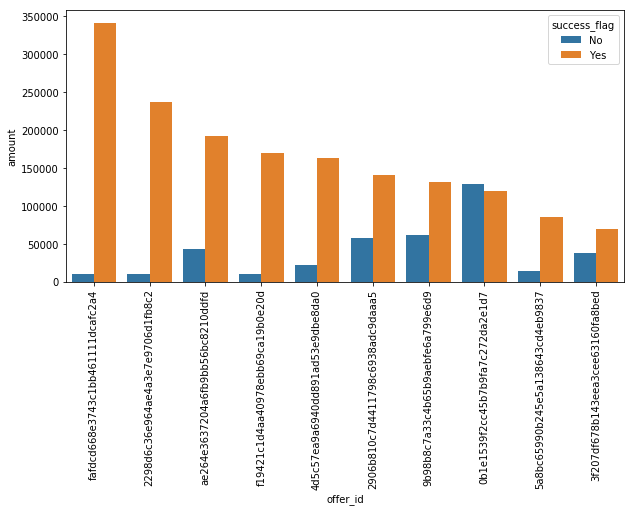

In [32]:
data = df[['offer_id', 'success_flag','amount']].groupby(['offer_id', 'success_flag']).sum()
data = data.reset_index()

data.columns = ['offer_id', 'success_flag', 'amount']
data = sort_data(data,'amount')
plt.figure(figsize=(10, 5))
sb.barplot(x='offer_id', y='amount', hue='success_flag', data=data)
plt.xticks(rotation=90)

Offers **fafdcd668e3743c1bb461111dcafc2a4** and **2298d6c36e964ae4a3e7e9706d1fb8c2** are the main drivers of sales. They are also the most successful offers in term of number of users responding to offers.

#### Impact of offer on successful response

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

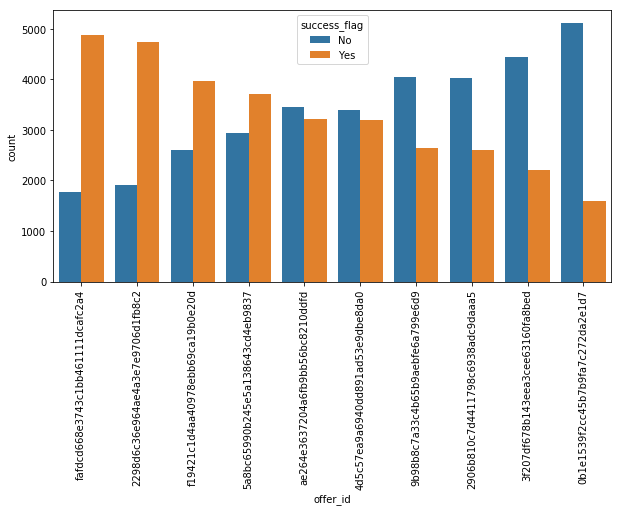

In [33]:
data = df.groupby(['offer_id', 'success_flag']).size()
data = data.reset_index()

data.columns = ['offer_id', 'success_flag', 'count']
data = sort_data(data,'count')
plt.figure(figsize=(10, 5))
sb.barplot(x='offer_id', y='count', hue='success_flag', data=data)
plt.xticks(rotation=90)

*The 3 most responded offers:*

 - fafdcd668e3743c1bb461111dcafc2a4
 - 2298d6c36e964ae4a3e7e9706d1fb8c2
 - f19421c1d4aa40978ebb69ca19b0e20d

*The 2 least responded offers:*

 - 3f207df678b143eea3cee63160fa8bed
 - 0b1e1539f2cc45b7b9fa7c272da2e1d7
 


#### Impact of offer duration on successful response

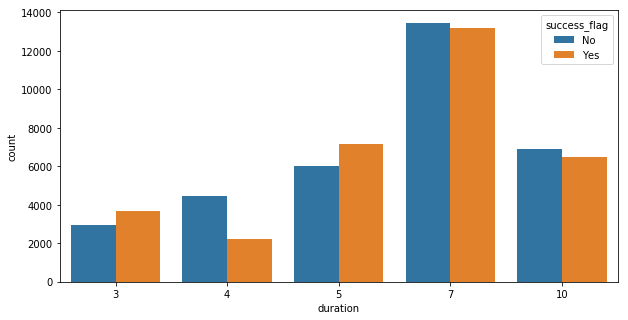

In [34]:
data = df.groupby(['duration', 'success_flag']).size()
data = data.reset_index()
data.columns = ['duration', 'success_flag', 'count']

plt.figure(figsize=(10, 5))
sb.barplot(x='duration', y='count', hue='success_flag', data=data)

*Offers with duration less than 5 days are less successful. Offer with duration of 7 days are more successful than those with duration of 5 or 10 days. Hence, users tend to consider 7 days duration as fair.*

#### Impact of offer reward on successful response

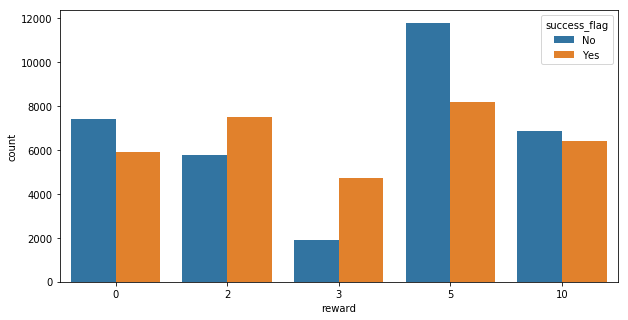

In [35]:
data = df.groupby(['reward', 'success_flag']).size()
data = data.reset_index()
data.columns = ['reward', 'success_flag', 'count']

plt.figure(figsize=(10, 5))
sb.barplot(x='reward', y='count', hue='success_flag', data=data)

*Offers with reward 3 are less successful than all others.*

#### Impact of offer difficulty on successful response

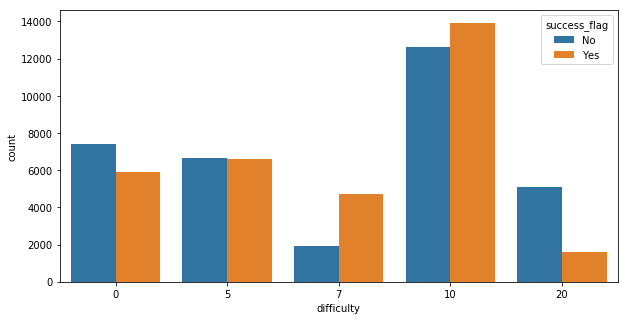

In [36]:
data = df.groupby(['difficulty', 'success_flag']).size()
data = data.reset_index()
data.columns = ['difficulty', 'success_flag', 'count']

plt.figure(figsize=(10, 5))
sb.barplot(x='difficulty', y='count', hue='success_flag', data=data)

*Offers with difficulty of 10 are the most responded. Those with difficulty of 20 are the least responded.*

#### Impact of offer type on successful response

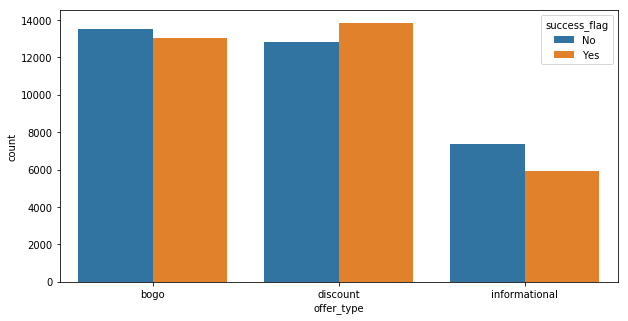

In [37]:
data = df.groupby(['offer_type', 'success_flag']).size()
data = data.reset_index()
data.columns = ['offer_type', 'success_flag', 'count']

plt.figure(figsize=(10, 5))
sb.barplot(x='offer_type', y='count', hue='success_flag', data=data)

*Offers of type discount are slightly more successful than those of type bogo. Offers of type informational are less sent out than others.*

#### Impact of offer type on sales

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

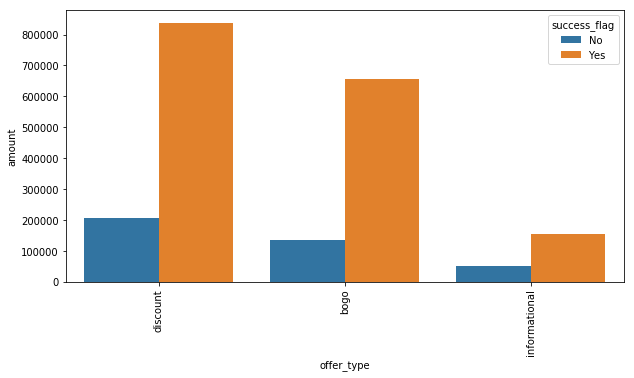

In [38]:
data = df[['offer_type', 'success_flag','amount']].groupby(['offer_type', 'success_flag']).sum()
data = data.reset_index()

data.columns = ['offer_type', 'success_flag', 'amount']
data = sort_data(data,'amount','offer_type')
plt.figure(figsize=(10, 5))
sb.barplot(x='offer_type', y='amount', hue='success_flag', data=data)
plt.xticks(rotation=90)

Offers of type discount and bogo are the main drivers of sales. Informational offers play a minor role. It becomes clear that people who respond to offers are those who make the most sales.

#### Impact of gender on successful response

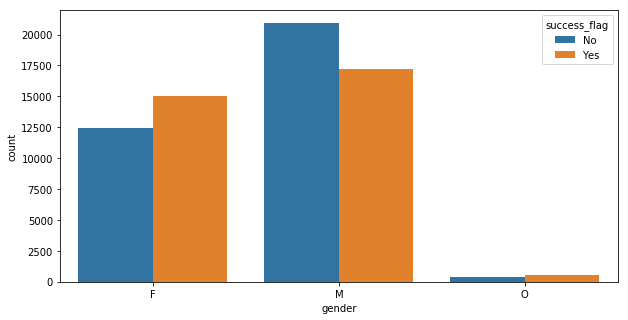

In [39]:
data = df.groupby(['gender', 'success_flag']).size()
data = data.reset_index()
data.columns = ['gender', 'success_flag', 'count']

plt.figure(figsize=(10, 5))
sb.barplot(x='gender', y='count', hue='success_flag', data=data)

There are in proportion more women who respond to offers than men. But in absolut value the number of men responding to different offers is higher than the number of women doing the same.

#### Impact of gender on sales

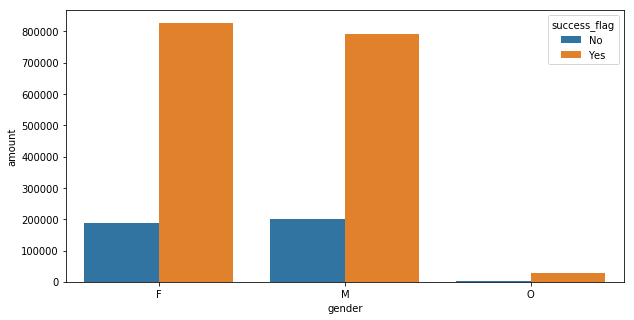

In [40]:
data = df[['gender', 'success_flag','amount']].groupby(['gender', 'success_flag']).sum()
data = data.reset_index()

data.columns = ['gender', 'success_flag', 'amount']
data = sort_data(data,'amount','gender')
plt.figure(figsize=(10, 5))
sb.barplot(x='gender', y='amount', hue='success_flag', data=data)
#plt.xticks(rotation=90)

Women produce more sales than men although they are less in number responding to different offers.

#### Impact of age on successful response and sales

In [41]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110','110-120']
df['age_range'] = pd.cut(df['age'], bins,labels=labels)
df.head()

,person_id,offer_id,amount,success_flag,difficulty,duration,reward,channel_mobile,channel_email,channel_social,channel_web,offer_type,age,income,gender,became_member_on_year,became_member_on_month,age_range
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,Yes,5,7,5,1,1,0,1,bogo,75,100000.0,F,2017,5,70-80
1,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,48.28,Yes,5,5,5,1,1,1,1,bogo,75,100000.0,F,2017,5,70-80
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,48.28,Yes,10,7,10,1,1,1,0,bogo,75,100000.0,F,2017,5,70-80
3,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,49.39,Yes,0,3,0,1,1,1,0,informational,75,100000.0,F,2017,5,70-80
4,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.67,No,5,7,5,1,1,0,1,bogo,59,41000.0,M,2015,1,50-60


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

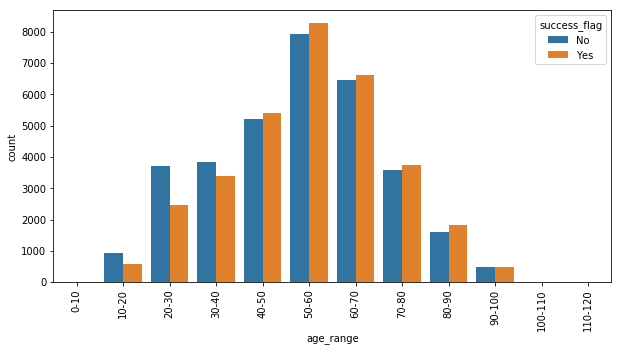

In [42]:
from matplotlib import pyplot as plt

data = df.groupby(['age_range', 'success_flag']).size()
data = data.reset_index()
data.columns = ['age_range', 'success_flag', 'count']

plt.figure(figsize=(10, 5))
sb.barplot(x='age_range', y='count', hue='success_flag', data=data)
plt.xticks(rotation=90)

The responding users are mostly between 40 and 70 years old.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

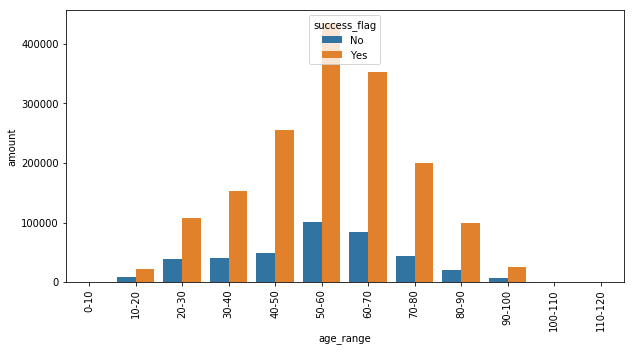

In [43]:
from matplotlib import pyplot as plt

data = df[['age_range', 'success_flag','amount']].groupby(['age_range', 'success_flag']).sum()
data = data.reset_index()
data.columns = ['age_range', 'success_flag', 'amount']

plt.figure(figsize=(10, 5))
sb.barplot(x='age_range', y='amount', hue='success_flag', data=data)
plt.xticks(rotation=90)

The responding user are mostly between 40 and 70 years old. They are the main drivers for sales. 

#### Impact of income/salary on successful response and sales

In [44]:
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000]
labels = ['0-10000','10000-20000','20000-30000','30000-40000','40000-50000','50000-60000','60000-70000','70000-80000','80000-90000','90000-100000','100000-110000','110000-120000','120000-130000']
df['income_range'] = pd.cut(df['income'], bins,labels=labels)
df.head()

,person_id,offer_id,amount,success_flag,difficulty,duration,reward,channel_mobile,channel_email,channel_social,channel_web,offer_type,age,income,gender,became_member_on_year,became_member_on_month,age_range,income_range
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,Yes,5,7,5,1,1,0,1,bogo,75,100000.0,F,2017,5,70-80,90000-100000
1,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,48.28,Yes,5,5,5,1,1,1,1,bogo,75,100000.0,F,2017,5,70-80,90000-100000
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,48.28,Yes,10,7,10,1,1,1,0,bogo,75,100000.0,F,2017,5,70-80,90000-100000
3,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,49.39,Yes,0,3,0,1,1,1,0,informational,75,100000.0,F,2017,5,70-80,90000-100000
4,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.67,No,5,7,5,1,1,0,1,bogo,59,41000.0,M,2015,1,50-60,40000-50000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

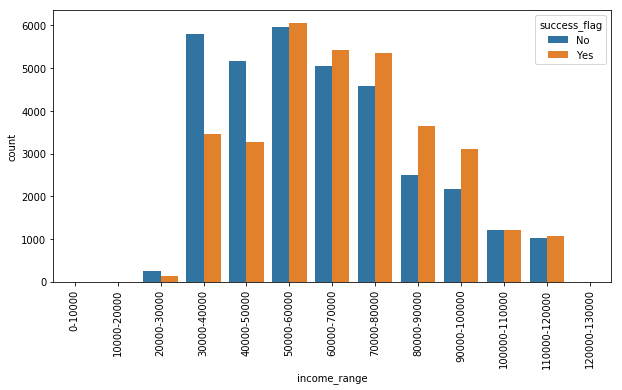

In [45]:
data = df.groupby(['income_range', 'success_flag']).size()
data = data.reset_index()
data.columns = ['income_range', 'success_flag', 'count']

plt.figure(figsize=(10, 5))
sb.barplot(x='income_range', y='count', hue='success_flag', data=data)
plt.xticks(rotation=90)

Users with income between 50000 and 80000 respond the most to different ofers.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

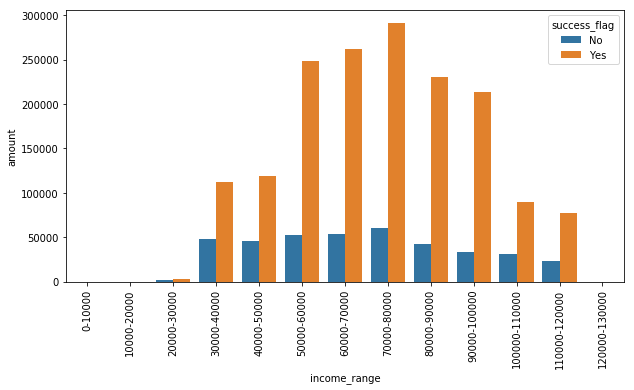

In [46]:
from matplotlib import pyplot as plt

data = df[['income_range', 'success_flag','amount']].groupby(['income_range', 'success_flag']).sum()
data = data.reset_index()
data.columns = ['income_range', 'success_flag', 'amount']

plt.figure(figsize=(10, 5))
sb.barplot(x='income_range', y='amount', hue='success_flag', data=data)
plt.xticks(rotation=90)

Users with income between 50000 and 100000 are those who make the most sales.

#### Final data cleaning for model building

In [47]:
irrelevant_columns = ['person_id','offer_id','age_range','income_range']
df.drop(irrelevant_columns,axis=1,inplace=True)

frames = [df,pd.get_dummies(df.gender, prefix='gender')]
df = pd.concat(frames, axis=1, sort=False)

frames = [df,pd.get_dummies(df.offer_type, prefix='offer_type')]
df = pd.concat(frames, axis=1, sort=False)

df = df.drop(['gender','offer_type'],axis=1)

df.to_csv("data/ML_df.csv",index=False)
print("ML df saved...")

df.head()

ML df saved...


,amount,success_flag,difficulty,duration,reward,channel_mobile,channel_email,channel_social,channel_web,age,income,became_member_on_year,became_member_on_month,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,37.67,Yes,5,7,5,1,1,0,1,75,100000.0,2017,5,1,0,0,1,0,0
1,48.28,Yes,5,5,5,1,1,1,1,75,100000.0,2017,5,1,0,0,1,0,0
2,48.28,Yes,10,7,10,1,1,1,0,75,100000.0,2017,5,1,0,0,1,0,0
3,49.39,Yes,0,3,0,1,1,1,0,75,100000.0,2017,5,1,0,0,0,0,1
4,0.67,No,5,7,5,1,1,0,1,59,41000.0,2015,1,0,1,0,1,0,0


# 4. Modelling

## Model that predicts whether or not someone will respond to an offer

In [48]:
ML_df = pd.read_csv("data/ML_df.csv")
ML_offer_response_df = ML_df.drop(['amount'],axis=1)
ML_offer_response_df['success_flag'] = ML_offer_response_df.success_flag.apply(lambda x: 1 if x=="Yes" else 0)
ML_offer_response_df.head()

,success_flag,difficulty,duration,reward,channel_mobile,channel_email,channel_social,channel_web,age,income,became_member_on_year,became_member_on_month,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,1,5,7,5,1,1,0,1,75,100000.0,2017,5,1,0,0,1,0,0
1,1,5,5,5,1,1,1,1,75,100000.0,2017,5,1,0,0,1,0,0
2,1,10,7,10,1,1,1,0,75,100000.0,2017,5,1,0,0,1,0,0
3,1,0,3,0,1,1,1,0,75,100000.0,2017,5,1,0,0,0,0,1
4,0,5,7,5,1,1,0,1,59,41000.0,2015,1,0,1,0,1,0,0


### Building the model

In [49]:
# label variable to predict
label = ML_offer_response_df.success_flag

# factors/features that influence the label variable
features = ML_offer_response_df.drop(['success_flag'],axis=1)

features.head(3)

,difficulty,duration,reward,channel_mobile,channel_email,channel_social,channel_web,age,income,became_member_on_year,became_member_on_month,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,5,7,5,1,1,0,1,75,100000.0,2017,5,1,0,0,1,0,0
1,5,5,5,1,1,1,1,75,100000.0,2017,5,1,0,0,1,0,0
2,10,7,10,1,1,1,0,75,100000.0,2017,5,1,0,0,1,0,0


In [50]:
# define min max scaler
scaler = MinMaxScaler()
# transform data
X_scaled = scaler.fit_transform(features.values)
# Split data in train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, label.values, test_size = 0.2, random_state=42)

###  Initial model definition and fitting

In [51]:
# Initial estimator
clf = RandomForestClassifier(n_estimators=100,max_depth=15,random_state=42, n_jobs=-1)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# 5. Model Evaluation

###  Initial model evaluation

In [52]:
print("Accuracy on train data: {:.2f}%".format(100.0*clf.score(X_train, y_train)))
print("Accuracy on test data: {:.2f}%".format(100.0*clf.score(X_test, y_test)))

y_train_preds = clf.predict(X_train)
y_test_preds = clf.predict(X_test)

print("")

print("F1 score on train data: {:.2f}%".format(100.0*f1_score(y_train_preds, y_train)))
print("F1 score on test data: {:.2f}%".format(100.0*f1_score(y_test_preds, y_test)))


Accuracy on train data: 84.35%
Accuracy on test data: 70.21%

F1 score on train data: 84.15%
F1 score on test data: 69.36%


***The model seems to be some how slightly overfitted. It does not generalized very well as the test performance is clearly low compared to training performance*** 

### Model feature importances

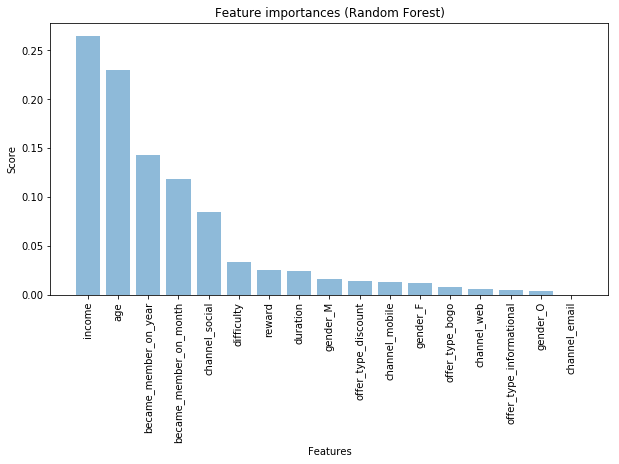

In [53]:
# Plotting feature importances
#============================

headers = ["name", "score"]
values = sorted(zip(features.columns, clf.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

feats = forest_feature_importances['name'][:]
y_pos = np.arange(len(feats))
scores = forest_feature_importances['score'][:]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, feats, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')
 
plt.show()


According to this initial model - *age* and *income* of the user of the starbuck app are the most important factors explaining the response to offers.

### Model cross validation - Applying RandomizedSearchCV

This task could take more than 5 minutes to complete.

In [54]:
# Model tunning - parameter selection with "randomized search CV"

n_estimators = [50,100,200]
max_depth = [20,30,40]
min_samples_split=[2,3,4]
min_impurity_decrease=[0.0001, 0.00001, 0.000001]

random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split':min_samples_split,
    'min_impurity_decrease': min_impurity_decrease
}

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

print("\n",rf_random.best_params_)

print("best_estimator - Accuracy on train data: {:.2f}".format(rf_random.best_estimator_.score(X_train, y_train)))
print("best_estimator - Accuracy on test data: {:.2f}".format(rf_random.best_estimator_.score(X_test, y_test)))
print("End of parameter selection...")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_samples_split=3, min_impurity_decrease=0.0001, max_depth=30 
[CV]  n_estimators=50, min_samples_split=3, min_impurity_decrease=0.0001, max_depth=30, total=   1.5s
[CV] n_estimators=50, min_samples_split=3, min_impurity_decrease=0.0001, max_depth=30 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=3, min_impurity_decrease=0.0001, max_depth=30, total=   1.5s
[CV] n_estimators=50, min_samples_split=3, min_impurity_decrease=0.0001, max_depth=30 
[CV]  n_estimators=50, min_samples_split=3, min_impurity_decrease=0.0001, max_depth=30, total=   1.4s
[CV] n_estimators=50, min_samples_split=3, min_impurity_decrease=0.0001, max_depth=30 
[CV]  n_estimators=50, min_samples_split=3, min_impurity_decrease=0.0001, max_depth=30, total=   1.5s
[CV] n_estimators=50, min_samples_split=3, min_impurity_decrease=0.0001, max_depth=30 
[CV]  n_estimators=50, min_samples_split=3, min_impurity_decrease=0.0001, max_depth=30, total=   1.5s
[CV] n_estimators=50, min_samples_split=2, min_impurity_decrease=0.0001, max_depth=20 
[CV]  n_estimators=50, min_samples_split=2, min_impurity_decrease=0.0001, max_depth=20, total=   1.5s
[CV] n_estimators=50, min_samples_split=2, min_impurity_decrease=0.0001, max_depth=20 
[CV]  n_estimators=50, min_samples_split=2, min_impurit

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished



 {'n_estimators': 100, 'min_samples_split': 4, 'min_impurity_decrease': 1e-05, 'max_depth': 40}
best_estimator - Accuracy on train data: 0.81
best_estimator - Accuracy on test data: 0.71
End of parameter selection...


### Evaluation of the best model

In [55]:
print("\nbest parameters: ",rf_random.best_params_)
print()
print("best_estimator - Accuracy on train data: {:.2f}%".format(100.0*rf_random.best_estimator_.score(X_train, y_train)))
print("best_estimator - Accuracy on test data: {:.2f}%".format(100.0*rf_random.best_estimator_.score(X_test, y_test)))
print()
print("best_estimator - f1_score on train data: {:.2f}%".format(100.0*f1_score(rf_random.best_estimator_.predict(X_train), y_train)))
print("best_estimator - f1_score on test data: {:.2f}%".format(100.0*f1_score(rf_random.best_estimator_.predict(X_test), y_test)))
print("\nEnd of parameter selection...")


best parameters:  {'n_estimators': 100, 'min_samples_split': 4, 'min_impurity_decrease': 1e-05, 'max_depth': 40}

best_estimator - Accuracy on train data: 81.41%
best_estimator - Accuracy on test data: 70.80%

best_estimator - f1_score on train data: 80.70%
best_estimator - f1_score on test data: 69.45%

End of parameter selection...


***The best model here is based on cross-validated parameters. It is therefore more stable than the initial model.***

### Feature importances after model selection

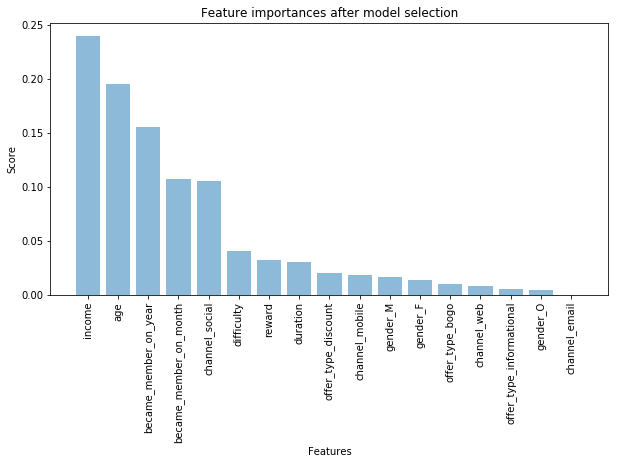

In [56]:
#Feature importances after model selection
headers = ["name", "score"]
values = sorted(zip(features.columns, rf_random.best_estimator_.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

feats = forest_feature_importances['name'][:]
y_pos = np.arange(len(feats))
scores = forest_feature_importances['score'][:]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, feats, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances after model selection')
 
plt.show()

The income and age of the users of tha starbuck app are the most important features for predicting whether a user will respond to an offer or not. These are followed by year/month where the user became member and the use of social media. Offer type and gender of the user play a second role in this context. The information about the email channel does not contribute that much.

# 6. Conclusion

The central problem I have chosen to solve in this Starbucks Capstone Challenge is predicting the responsiveness of a user to a given offer sent through Starbuck reward app.

The combination of transaction data, profile and portfolio data inevitably leads to the question of the predictability of the outcome of transactional interactions. The data preparation phase of this project was particularly challenging as different transactional interactions (receive, view, complete) have to be combined logically in order to replicate the right sense of the offer and transaction process. 
After merging combined transactional data to profile and portfolio data, an exploratory analysis has made some insights visible. Hence, the questions asked in section 1. could be answered.

**- Which are the most accepted offers ?**

The following 3 offers have been mostly responded by users.They are the most accepted offers so far:

    - fafdcd668e3743c1bb461111dcafc2a4
    - 2298d6c36e964ae4a3e7e9706d1fb8c2
    - f19421c1d4aa40978ebb69ca19b0e20d

**- Which are the most beneficial offers from the perspective of revenues ?**

The following two offers have generated the highest revenue

    - fafdcd668e3743c1bb461111dcafc2a4
    - 2298d6c36e964ae4a3e7e9706d1fb8c2
    
The 2 most successful offers are of type "discount", have a duration of 7 or 10 days and reward of 2 or 3.
    
**- What is the profile of the typical/ideal target user (age, income, gender) ?**

The typical/ideal target user are basically those who respond to offers and allow for generating revenue. As seen in exploratory analysis, users aged between 40 and 70 years having an income between 50000 and 100000 are those who respond the most to different offers and generate the highest revenues. Women respond proportionally more than men and generated more revenue than men. It would make sens to invest in getting more women as member.

**- Could the response of a given user to a given offer be precited ? Will a given user respond to a given offer ?**

The predictive model build in this project is a classifier based on random forest logics.The best cross-validated model which is the one with the best average performance shows 81.41% accuracy on training data and 70.80% accuracy on test data. The f1-scores of 80.70% on training data and 69.45% on test data are at the same range as accuracy scores above. Hence, it could be predicted with at least 70.80% accuracy whether a user will respond to an offer or not. 

**- What are the most importants factors when it is about to predict the responsiveness of a user to an offer ?**

The age and income of the users are the most important factors explaining the responsiveness of the users to different offers. However, the year/month where the user became a member expressing the loyality are also important role in this context. The use of social media also one of the 5 most important factors according to the model.

However, the performance results achieved here could be improved using different machine learning techniques like parameter tuning or the use of other classification models. 